In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
path = '/content/drive/My Drive/kaggle/atmacup5/'
os.chdir(path) # カレントディレクトリを指定
os.getcwd()

'/content/drive/My Drive/kaggle/atmacup5'

In [ ]:
# !pip install transformers
# !pip install pytorch-transformers
# !pip install japanize-matplotlib
!pip install keras-radam

  Created wheel for keras-radam: filename=keras_radam-0.15.0-cp36-none-any.whl size=14685 sha256=fe417afd5bf2de9229fb265058053f9efb130b3ba7a62b48425b7bea8c216ec8
  Stored in directory: /root/.cache/pip/wheels/79/a0/c0/670b0a118e8f078539fafec7bd02eba0af921f745660c7f83f
Successfully built keras-radam


# Code

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import os
import gc
import glob
import pickle
# import japanize_matplotlib
from tqdm import tqdm_notebook as tqdm

import os
os.environ['TF_KERAS'] = '1'

## CNN
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from keras_radam import RAdam

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import average_precision_score

## 次元圧縮
import umap
from scipy.sparse.csgraph import connected_components

In [ ]:
INPUT_DIR = "./data/"
df_train = pd.read_csv(INPUT_DIR + "train.csv")
df_fitting = pd.read_csv(INPUT_DIR + "fitting.csv")
df_test = pd.read_csv(INPUT_DIR + "test.csv")

df_train = pd.merge(df_train, df_fitting, on="spectrum_id", how="left")
df_test = pd.merge(df_test, df_fitting, on="spectrum_id", how="left")

spectrum_dir = INPUT_DIR + "spectrum_raw/"

OUTPUT_DIR = "./output/"
MODEL_DIR = OUTPUT_DIR + "model/"
FIG_DIR = OUTPUT_DIR + "fig/"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# Data Load

In [ ]:
def load_dat(spectrum_file, params2, length=128):

    ## Datファイルの読み込み
    dat_df = pd.read_csv(spectrum_dir + spectrum_file,
                         header=None,
                         sep="\t")

    ## カラム名変更
    dat_df.columns = ["WaveLength", "SignalPower"]

    ## 波長データは使わず、光強度のみを使います
    intensity = dat_df["SignalPower"][:511].to_numpy()
    max_idx = params2 # np.argmax(intensity)

    if len(intensity) - max_idx < int(length / 2):
      intensity = intensity[-length:]
    elif max_idx < int(length / 2):
      intensity = intensity[: length]
    else:
        intensity = intensity[int(max_idx - (length / 2)): int(max_idx + (length / 2))]

    return intensity

def min_max_scale(spectrum):

    ## 波形そのものが重要そうですので、0~1に正規化します
    spectrum = (spectrum - np.min(spectrum)) / (np.max(spectrum) - np.min(spectrum))

    return spectrum

In [ ]:
# y_group = df_train["chip_id"].values
# np.save('./data/y_group_data.npy', y_group)
# y_group = np.load('./data/y_group_data.npy', allow_pickle=True)

In [ ]:
length = 511
# X_train = np.empty((len(df_train), length), dtype="float")
# X_train_filelist = df_train["spectrum_filename"].tolist()
# X_params2 = df_train["params2"].tolist()
# y_train = df_train["target"].values

# for i, (spectrum_file, params2) in tqdm(enumerate(zip(X_train_filelist, X_params2))):

#     ## datから光強度のみ読み込み
#     specrum = load_dat(spectrum_file, params2, length)

#     ## 正規化
#     specrum = min_max_scale(specrum)

#     X_train[i,:] = specrum


# X_train = X_train.reshape(-1, length, 1)



# np.save('./data/cavity_peak128_X_train_spectrum_data.npy', X_train)
# np.save('./data/cavity_peak128_y_train_spectrum_dat.npy', y_train)

X_train = np.load('./data/X_train_spectrum_data.npy')
y_train = np.load('./data/y_train_spectrum_dat.npy')
# X_train = np.load('./data/peak128_X_train_spectrum_data.npy')
# y_train = np.load('./data/peak128_y_train_spectrum_dat.npy')
y_group = np.load('./data/y_group_data.npy',  allow_pickle=True)

print(X_train.shape, y_train.shape, y_group.shape)

(7436, 511, 1) (7436, 1) (7436,)


In [ ]:
# X_test = np.empty((len(df_test), length), dtype="float")
# X_test_filelist = df_test["spectrum_filename"].tolist()
# X_params2 = df_test["params2"].tolist()

# for i, (spectrum_file, params2) in tqdm(enumerate(zip(X_test_filelist, X_params2))):

#     ## datから光強度のみ読み込み
#     specrum = load_dat(spectrum_file, length)

#     ## 正規化
#     specrum = min_max_scale(specrum)

#     X_test[i,:] = specrum


# X_test = X_test.reshape(-1, length, 1)

# np.save('./data/cavity_peak128_X_test_spectrum_data.npy', X_test)

# X_test = np.load('./data/peak128_X_test_spectrum_data.npy')
X_test = np.load('./data/X_test_spectrum_data.npy')

print(X_test.shape)

(6952, 511, 1)


# Wave Check

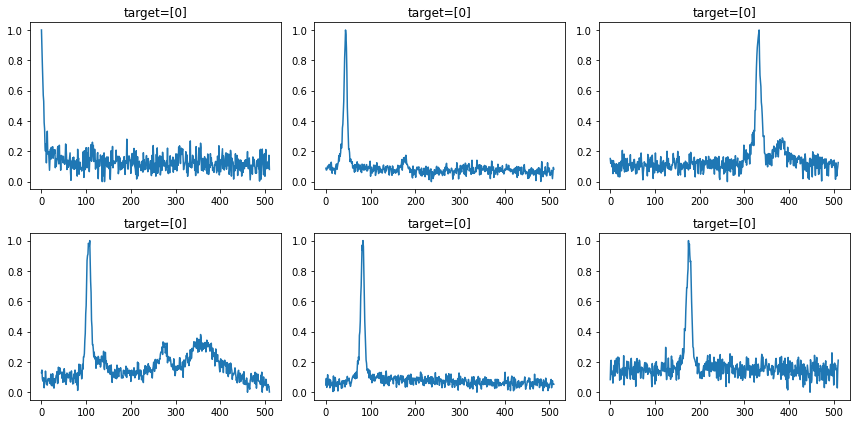

In [ ]:
plt.figure(figsize=(12, 6), tight_layout=True)

for i in range(6):

    plt.subplot(2,3,i+1)
    plt.plot(X_train[i,:])
    plt.title("target={}".format(y_train[i]))

plt.show()

# Reshape

In [ ]:
# X_train = X_train.reshape(-1, 511, 1)
# X_test = X_test.reshape(-1, 511, 1)
y_train = y_train.reshape(-1, 1)

print(X_train.shape, X_test.shape, y_train.shape)

(7436, 511, 1) (6952, 511, 1) (7436, 1)


# Model

In [ ]:
# 採用モデル
def create_model(input_len, n_filter, filter_size, drop_rate):
  def cnn_layer(_input, n_filter, filter_size, padding='same'):
    x = Conv1D(n_filter, filter_size, padding=padding)(_input)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(drop_rate)(x)
    return x

  ## 入力の型を定義
  _input = Input((input_len, 1))

  ## 畳み込みブロック(過学習防止にdropoutも追加します)
  # x = BatchNormalization()(_input)
  x = cnn_layer(_input, 64, 5, padding="same")
  x = cnn_layer(x, 128, 3, padding="same")
  x = cnn_layer(x, 256, 3, padding="same")
  x = cnn_layer(x, 128, 3, padding="same")
  x = cnn_layer(x, 64, 5, padding="same")

  ## あとで挙動を確認したいので、この層に名前をつけます
  x = GlobalMaxPool1D(name="hidden")(x)
  x = Dropout(drop_rate)(x)

  ## 0 or 1を当てるのでsigmoidを使います
  _out = Dense(1, activation="sigmoid")(x)

  model = Model(_input, _out, name="Sequential")

  return model

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz=None):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden=None):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # スコアを計算するためにこのように加算を実行する
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # スコアを self.V に適用するために最後の軸は 1 となる
    # self.V に適用する前のテンソルの shape は  (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights の shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector の合計後の shape == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


def create_model(input_len, n_filter, filter_size, drop_rate):
  def cnn_layer(_input, n_filter, filter_size, padding='same'):
    x = Conv1D(n_filter, filter_size, padding=padding)(_input)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(drop_rate)(x)
    return x

  _input = Input((input_len))
  encoder = Encoder(32000, 256, length)
  # hidden_state = tf.zeros(256, 1)
  output, hidden_state = encoder(_input, hidden=None)

  attention_layer = BahdanauAttention(10)
  attention_result, attention_weights = attention_layer(hidden_state, output)

  ## 0 or 1を当てるのでsigmoidを使います
  _out = Dense(1, activation="sigmoid")(attention_result)

  model = Model(_input, _out, name="Sequential")

  return model

In [ ]:
def create_model(input_len, n_filter, filter_size, drop_rate):
  def cnn_layer(_input, n_filter, filter_size, padding='same'):
    x = Conv1D(n_filter, filter_size, padding=padding)(_input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(drop_rate)(x)
    return x
  ## 入力の型を定義
  _input = Input((input_len, 1))

  x1 = cnn_layer(_input, 64, 3, padding="same")
  x = cnn_layer(x1, 64, 3, padding="same")
  x = cnn_layer(x, 64, 3, padding="same")
  x = tf.keras.layers.add([x1, x])
  x = MaxPool1D(2, 2)(x)

  x2 = cnn_layer(x, 64, 3, padding="same")
  x = cnn_layer(x2, 64, 3, padding="same")
  x = cnn_layer(x, 64, 3, padding="same")
  x = tf.keras.layers.add([x2, x])
  x = MaxPool1D(2, 2)(x)

  x3 = cnn_layer(x, 128, 3, padding="same")
  x = cnn_layer(x3, 128, 3, padding="same")
  x = cnn_layer(x, 128, 3, padding="same")
  x = tf.keras.layers.add([x3, x])
  x = MaxPool1D(2, 2)(x)

  x4 = cnn_layer(x, 128, 3, padding="same")
  x = cnn_layer(x4, 128, 3, padding="same")
  x = cnn_layer(x, 128, 3, padding="same")
  x = tf.keras.layers.add([x4, x])
  x = GlobalMaxPool1D()(x)

  # classifer
  x = Dense(1024)(x)
  x = Activation("relu")(x)
  x = Dropout(0.5)(x)
  x = Dense(512)(x)
  x = Activation("relu")(x)
  x = Dropout(0.5)(x)
  _out = Dense(1, activation="sigmoid")(x)
  model = Model(_input, _out, name="Sequential")

  return model

In [ ]:
def create_model(input_len, n_filter, filter_size, drop_rate):
  def cnn_layer(_input, n_filter, filter_size, padding='same'):
    x = Conv1D(n_filter, filter_size, padding=padding)(_input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(drop_rate)(x)
    return x

  ## 入力の型を定義
  _input = Input((input_len, 1))
  conv = cnn_layer(_input, 32, 3, padding="same")
  x = tf.keras.backend.mean(conv, axis=-1)
  x = Dense(input_len//2)(x)
  x = Dropout(drop_rate)(x)
  x = Activation("relu")(x)
  x = Dense(input_len)(x)
  x = Dropout(drop_rate)(x)
  x = tf.keras.backend.expand_dims(x, -1)
  x = _input * x

  x = tf.squeeze(x, -1)
  x = Dropout(drop_rate)(x)

  ## 0 or 1を当てるのでsigmoidを使います
  _out = Dense(1, activation="sigmoid")(x)

  model = Model(_input, _out, name="Sequential")

  return model

In [ ]:
model = create_model(input_len=length, n_filter=64, filter_size=8, drop_rate=0.3)
model.summary()

Model: "Sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_322 (InputLayer)       [(None, 511, 1)]          0         
_________________________________________________________________
conv1d_1438 (Conv1D)         (None, 511, 64)           576       
_________________________________________________________________
activation_1610 (Activation) (None, 511, 64)           0         
_________________________________________________________________
batch_normalization_1196 (Ba (None, 511, 64)           256       
_________________________________________________________________
dropout_1562 (Dropout)       (None, 511, 64)           0         
_________________________________________________________________
conv1d_1439 (Conv1D)         (None, 511, 128)          65664     
_________________________________________________________________
activation_1611 (Activation) (None, 511, 128)          0

# Extract Features

In [ ]:
def extra_dist(best_model):

    ## 中間層を出力するためのモデル
    layer_name = 'hidden'
    hidden_model = Model(inputs=best_model.input,
                         outputs=best_model.get_layer(layer_name).output)


    ## trainを入力し、64次元のベクトル抽出
    hidden_pred_train = hidden_model.predict(X_skf_train)
    hidden_pred_test = hidden_model.predict(X_skf_test)

    ## UMAPによる次元圧縮
    trans = umap.UMAP(n_components=2, random_state=42)
    train_dist = trans.fit(hidden_pred_train)
    test_dist = trans.transform(hidden_pred_test)

    return train_dist, test_dist

In [ ]:
def augment_true_examples(X_train, y_train):
    
    # 反転
    X_aug = X_train[y_train.flatten()==1, ::-1].copy()
    y_aug = np.ones((X_aug.shape[0], 1))
    # group_aug = y_group[y_train.flatten()==1]
    #今は所属するchip_idとか気にせず実装
    X_out = np.r_[X_train, X_aug]
    y_out = np.r_[y_train, y_aug]
    return X_out, y_out

In [ ]:
## oofと提出用ファイル
OOF = pd.DataFrame(columns=["oof"])
PRED = pd.DataFrame(columns=["target"])

oof = np.zeros(X_train.shape[0])
test_ = np.zeros(X_test.shape[0])

In [ ]:
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
gkf = GroupKFold(len(set(y_group)))

cv= 1
scores = []

# y_group2 = np.where(y_group=='c695a1e61e002b34e556', '6718e7f83c824b1e436d', y_group)

for train_idx, test_idx in skf.split(X_train, y_train[:,0]):
# for train_idx, test_idx in gkf.split(X_train, groups=y_group):

    print("#"*50)
    print('validation chip_id: ', y_group[test_idx[0]])
    # if y_group[test_idx[0]]=='c695a1e61e002b34e556':
    #   print('break because val data has chip id : c695a1e61e002b34e556')
    #   continue
    print("CV={}".format(cv))


    X_skf_train = X_train[train_idx,:,:].copy()
    y_skf_train = y_train[train_idx,:].copy()
    X_skf_test = X_train[test_idx,:].copy()
    y_skf_test = y_train[test_idx,:].copy()

    X_skf_train, y_skf_train = augment_true_examples(X_skf_train, y_skf_train)

    ## CVごとにモデル作成
    model = create_model(input_len=length, n_filter=64, filter_size=8, drop_rate=0.1)
    
    model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=[AUC(curve='PR', num_thresholds=1000)])

    ## 学習, bestmodelをsave
    ckp = ModelCheckpoint(filepath=MODEL_DIR + 'best_weight_cv_{}.h5'.format(cv),
                          verbose=1, save_best_only=True)

    history = model.fit(X_skf_train,y_skf_train,
                        validation_data=(X_skf_test, y_skf_test),
                        epochs=30,
                        batch_size=16,
                        verbose=1,
                        callbacks=[ckp])

    ## 中間ベクトルを取り出すためのモデル
    pred_model = create_model(input_len=length, n_filter=64, filter_size=8, drop_rate=0.1)
    pred_model.load_weights(MODEL_DIR + 'best_weight_cv_{}.h5'.format(cv))

    # ## 中間ベクトル
    # train_dist, test_dist = extra_dist(pred_model)

    # ## 中間ベクトル→次元圧縮→可視化
    # plt.figure(figsize=(8,4), tight_layout=True)
    # plt.subplot(1,2,1)
    # plt.scatter(train_dist.embedding_[:,0], train_dist.embedding_[:,1],
    #             c=y_skf_train[:, 0],
    #             cmap="bwr",
    #             alpha=0.3,
    #             s=10)
    # plt.title("Train distribution CV={}".format(cv))
    # plt.colorbar()

    # plt.subplot(1,2,2)
    # plt.scatter(test_dist[:,0], test_dist[:,1],
    #             c=y_skf_test[:, 0],
    #             cmap="bwr",
    #             alpha=0.3,
    #             s=10)
    # plt.title("Valid distribution CV={}".format(cv))
    # plt.colorbar()
    # plt.savefig(FIG_DIR + "CV_{}_dist.png".format(cv))
    # plt.close()

    oof[test_idx] = pred_model.predict(X_skf_test)[:,0]
    test_ += pred_model.predict(X_test)[:,0]

    ## 後処理
    score = average_precision_score(y_skf_test[:,0], oof[test_idx])
    print("auc: {}".format(score))
    scores.append(score)

    cv += 1
    print("#"*50)


OOF["oof"] = oof
PRED["target"] = test_ / len(set(y_group))

print('*'*5 + 'cv_scores' + '*'*5)
print(scores)
print('mean: ', sum(scores) / len(scores))

##################################################
validation chip_id:  c695a1e61e002b34e556
CV=1
Epoch 1/30
384/384 [==============================] - ETA: 0s - loss: 0.2528 - auc_174: 0.4415
Epoch 00001: val_loss improved from inf to 1.03398, saving model to ./output/model/best_weight_cv_1.h5
384/384 [==============================] - 5s 12ms/step - loss: 0.2528 - auc_174: 0.4415 - val_loss: 1.0340 - val_auc_174: 0.6716
Epoch 2/30
379/384 [============================>.] - ETA: 0s - loss: 0.1325 - auc_174: 0.7158
Epoch 00002: val_loss improved from 1.03398 to 0.23760, saving model to ./output/model/best_weight_cv_1.h5
384/384 [==============================] - 4s 10ms/step - loss: 0.1317 - auc_174: 0.7179 - val_loss: 0.2376 - val_auc_174: 0.7705
Epoch 3/30
380/384 [============================>.] - ETA: 0s - loss: 0.1096 - auc_174: 0.7635
Epoch 00003: val_loss improved from 0.23760 to 0.14324, saving model to ./output/model/best_weight_cv_1.h5
384/384 [==============================]

In [ ]:
# group
# [0.8915054679843909, 0.9280776431445731, 0.9451601812973992, 0.8401032382650031, 0.7532007782397925]
# mean:  0.8716094617862318


# stratified, cnn3layer LB: 0.8517
# [0.8596173558890617, 0.8930273484030135, 0.8589321420072333, 0.8772152819907734, 0.9311715005110076]
# mean:  0.8839927257602179

# cnn4layer
# mean: 0.889~

In [ ]:
# group, epoch20, layer2
# [0.8626271475418242, 0.8893749381439591, 0.8929530243182315, 0.7724226234760937, 0.584287254723204]
# mean:  0.8003329976406626

# group, epoch20, layer3
# [0.8629792112771089, 0.9009815114460377, 0.956436420722135, 0.8142329036026734, 0.5986732214905874]
# mean:  0.8266606537077085

# wavelength 128, layer3
# [0.8030649731940592, 0.8721255014371786, 0.7437937937601394, 0.8147053152252459, 0.4980302060437369]
# mean:  0.746343957932072

# NFL like
#   [0.8280666459084327, 0.8559431246980935, 0.8973134008848294, 0.8417768959435626, 0.4571640711631386]
# mean:  0.7760528277196114

# filter size3, layer6
# [0.7745216305006564, 0.8246248084106632, 0.7623247783962068, 0.5354885155857443, 0.42234718595119497]
# mean:  0.6638613837688931


# 最初にbn, group, epoch20, layer3
# [0.8591894203753706, 0.9035039922852306, 0.9025810324129652, 0.739959080951728, 0.6051300996866229]
# mean:  0.8020727251423836

# 最初にbn, group, epoch20, layer3, dropout0.1
# [0.8934893653655573, 0.9146968875631495, 0.9425660318517461, 0.7961271327650637, 0.7167268998538441]
# mean:  0.8527212634798721

# group, epoch20, layer3, dropout0.1
# [0.8834709718972978, 0.9209054439294202, 0.9723766429648781, 0.855151633430322, 0.7298610149422444]
# mean:  0.8723531414328324

# [0.8574657557485329, 0.9152066037167094, 0.9552197802197802, 0.7769335988085987, 0.8040363849472377]
# mean:  0.8617724246881717

# group, epoch20, layer4, dropout0.1
# [0.8618957308742331, 0.9048090243824805, 0.9634294277151418, 0.8196792919473563, 0.6608065849999136]
# mean:  0.842124011983825


# group, epoch20, layer3, dropout0.1, aug
# [0.8769371487065777, 0.9245372042583949, 0.9463976499690784, 0.808033138636587, 0.803155163130542]
# 0.871812060940236

# [0.8908373779964885, 0.911264660258847, 0.969108669108669, 0.7690086483564744, 0.8427884824063462]
# mean:  0.8766015676253651

# [0.8826943742635528, 0.924872225143971, 0.9476007326007325, 0.7879289392524687, 0.8425425363884413]
# mean:  0.8771277615298333


# stratified, epoch20, layer3, dropout0.1, aug
# [0.8711369816230714, 0.8845840684341746, 0.8770897860632741, 0.8695042804671035, 0.9239265707893982]
# mean:  0.8852483374754044

# もとのやつ + aug, RAdam
# [0.8520654265928131, 0.8360789426890808, 0.7900408304111338, 0.8251719900913922, 0.8930922382221504]
# mean:  0.839289885601314


# group, epoch20, layer3, dropout0.1, aug、RAdam
# [0.8655686854663046, 0.9137087625565452, 0.9227513227513227, 0.7695881551273709, 0.5598044747968683]
# mean:  0.8062842801396825



# submit

In [ ]:
sub = pd.read_csv(INPUT_DIR + 'atmaCup5__sample_submission.csv')
sub['target'] = PRED
sub.head()

,target
0,0.072384
1,0.041982
2,0.053015
3,0.035808
4,0.092102


In [ ]:
import datetime

now = datetime.datetime.now()
now = now.strftime("%m%d_%H%M%S")

sub.to_csv(f'./output/submission_{now}.csv', index=False)

In [ ]:
print(now)

0606_085814
